<a href="https://colab.research.google.com/github/EElkina/Predict_composite_materials_characteristics/blob/main/Predict_composite_materials_characteristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font color='purple'><b> Цель проекта </b></font> - построение модели для предсказания конечных свойст композиционных материалов (упругость и прочность при растяжении).  
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. 


#1. Загрузка данных

In [1]:
#Рассмотрим датасеты, выявим целевую переменную и признаки. 

In [2]:
!pip install catboost
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import scipy as sp
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import pylab
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import pylab
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
drive.mount('/content/drive')
!cd /content/drive/My Drive
!mkdir mydirectory
!cd mydirectory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 0: cd: too many arguments


In [5]:
xbp_df = pd.read_excel('/content/drive/MyDrive/Python/Baumanka/Composite_materials/X_bp.xlsx', index_col=0)
xnup_df = pd.read_excel('/content/drive/MyDrive/Python/Baumanka/Composite_materials/X_nup.xlsx', index_col=0)

In [6]:
#характеристики базальтопластика
xbp_df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0.0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1.0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2.0,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3.0,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4.0,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [7]:
#характеристики нашивок
xnup_df.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0.0,0.0,4.0,57.0
1.0,0.0,4.0,60.0
2.0,0.0,4.0,70.0
3.0,0.0,5.0,47.0
4.0,0.0,5.0,57.0


In [8]:
print (type(xnup_df))
print (type(xbp_df))
print (xnup_df.shape)
print (xbp_df.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1040, 3)
(1023, 10)


In [9]:
#Объединим характеристики материалов в одну таблицу
#INNER JOIN (по умолчанию в pandas) - объединяются только те значения, которые можно найти в обеих таблицах

df = xbp_df.join(xnup_df)
df.shape

(1023, 13)

In [10]:
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0.0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0,0.0,4.0,57.0
1.0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,60.0
2.0,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,70.0
3.0,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0.0,5.0,47.0
4.0,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0.0,5.0,57.0


Посмотрим, сколько и какие материалы (их индексы) нам пришлось выкинуть из рассмотрения,так как для них не нашлось данных в таблице xbp_df

In [11]:
df_1040 = xnup_df.join(xbp_df)
df_1040.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1040 entries, 0.0 to 1039.0
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Угол нашивки, град                    1040 non-null   float64
 1   Шаг нашивки                           1040 non-null   float64
 2   Плотность нашивки                     1040 non-null   float64
 3   Соотношение матрица-наполнитель       1023 non-null   float64
 4   Плотность, кг/м3                      1023 non-null   float64
 5   модуль упругости, ГПа                 1023 non-null   float64
 6   Количество отвердителя, м.%           1023 non-null   float64
 7   Содержание эпоксидных групп,%_2       1023 non-null   float64
 8   Температура вспышки, С_2              1023 non-null   float64
 9   Поверхностная плотность, г/м2         1023 non-null   float64
 10  Модуль упругости при растяжении, ГПа  1023 non-null   float64
 11  Прочность п

In [12]:
df_not_machted = df_1040.loc[df_1040.loc[:, 'Соотношение матрица-наполнитель'].isna()]

In [13]:
deleted_materials = df_not_machted.index.unique()
deleted_materials

Float64Index([1023.0, 1024.0, 1025.0, 1026.0, 1027.0, 1028.0, 1029.0, 1030.0,
              1031.0, 1032.0, 1033.0, 1034.0, 1035.0, 1036.0, 1037.0, 1038.0,
              1039.0],
             dtype='float64')

In [14]:
len(deleted_materials)

17

Итак, 17 материалов пришлось исключить. Рассмотрим оставшийся объединенный датасет:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки

In [16]:
#Сколько материалов с характеристиками в таблице
df.index.unique()

Float64Index([   0.0,    1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,
                 8.0,    9.0,
              ...
              1013.0, 1014.0, 1015.0, 1016.0, 1017.0, 1018.0, 1019.0, 1020.0,
              1021.0, 1022.0],
             dtype='float64', length=1023)

In [17]:
df.isna().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

In [18]:
df.duplicated().sum()

0

1024 записи, пропусков нет, дубликатов нет, у всех параметров тип float64

Исправим тип float на int для индекса (id материала)

In [19]:
df.index = df.index.astype(int)

In [20]:
df.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

Целевые переменные для моделирования - Модуль упругости при растяжении, ГПа и Прочность при растяжении, МПа.

#2. Предобработка данных

Внимательно посмотрим на каждый столбец-параметр на предмет ошибок, аномальных значений

In [21]:
df.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,2.930366,1975.734888,739.923233,110.570769,22.244390,285.882151,482.731833,73.328571,2466.922843,218.423144,44.252199,6.899222,57.153929
std,0.913222,73.729231,330.231581,28.295911,2.406301,40.943260,281.314690,3.118983,485.628006,59.735931,45.015793,2.563467,12.350969
min,0.389403,1731.764635,2.436909,17.740275,14.254985,100.000000,0.603740,64.054061,1036.856605,33.803026,0.000000,0.000000,0.000000
25%,2.317887,1924.155467,500.047452,92.443497,20.608034,259.066528,266.816645,71.245018,2135.850448,179.627520,0.000000,5.080033,49.799212
50%,2.906878,1977.621657,739.664328,110.564840,22.230744,285.896812,451.864365,73.268805,2459.524526,219.198882,0.000000,6.916144,57.341920
75%,3.552660,2021.374375,961.812526,129.730366,23.961934,313.002106,693.225017,75.356612,2767.193119,257.481724,90.000000,8.586293,64.944961
max,5.591742,2207.773481,1911.536477,198.953207,33.000000,413.273418,1399.542362,82.682051,3848.436732,414.590628,90.000000,14.440522,103.988901


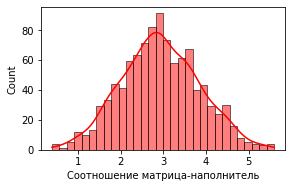

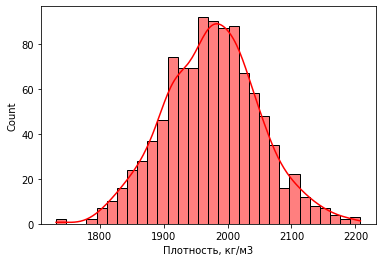

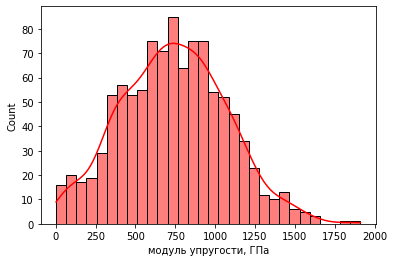

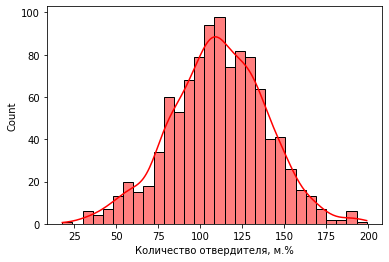

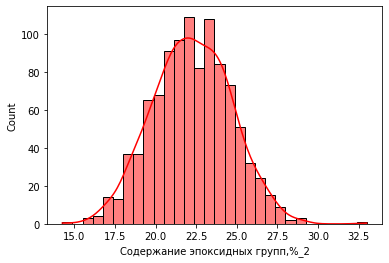

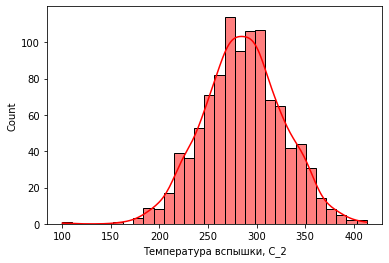

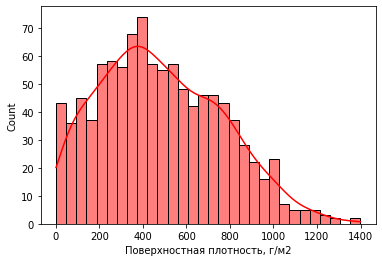

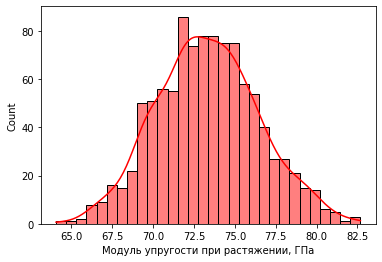

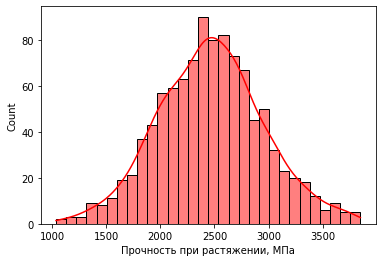

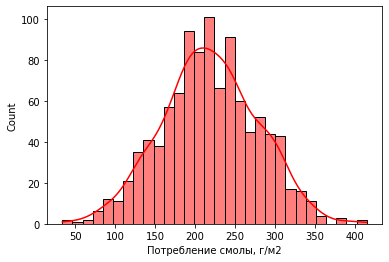

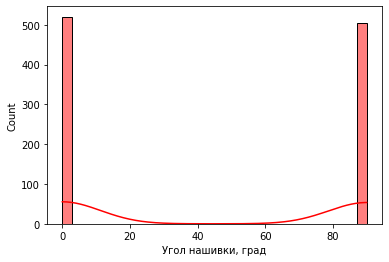

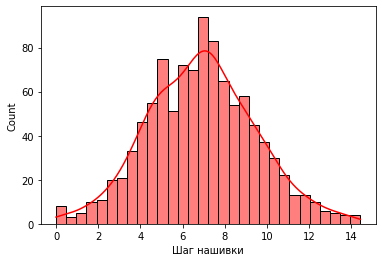

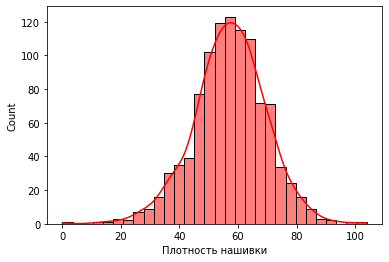

In [22]:
from matplotlib.colorbar import colorbar_factory
def histodraw(df, variables, n_rows, n_cols):
 fig=plt.figure(figsize=(15, 10))
 for i, var_name in enumerate(variables):
  ax=fig.add_subplot(n_rows,n_cols,i+1)
  sns.histplot(data=df, x=var_name, kde=True, bins=30, color = 'red')
  fig.tight_layout()
  plt.show()
histodraw(df, df.columns, 4, 4)

Практически все параметры распределены нормально, кроме:  
1. Угла нашивки (этот параметр принимает три значения: 0,45,90 градусов);
2. Поверхностная плотность - гарфик смещен влево, т.е. есть хвост справа (есть небольшое кол-во материалов с высокой плотностью).Посмотрим выбросы на диаграммах рассеняния

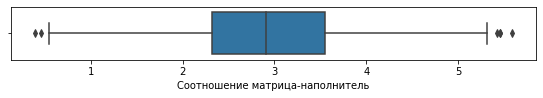

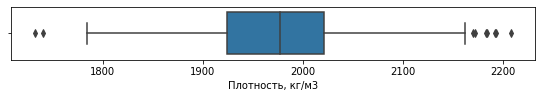

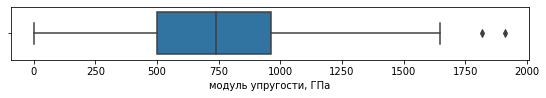

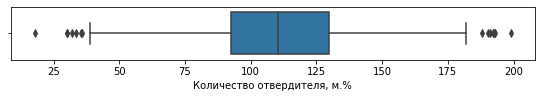

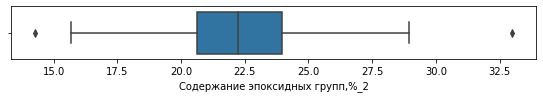

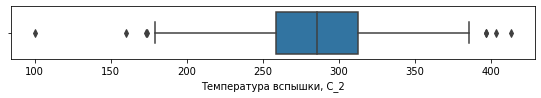

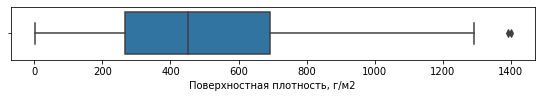

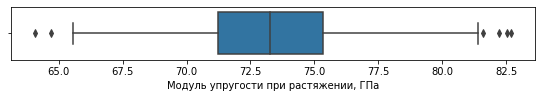

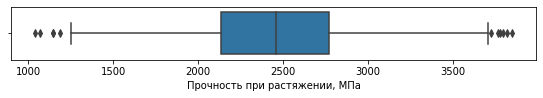

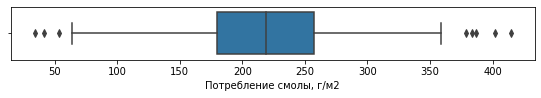

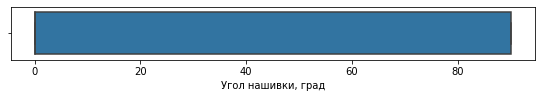

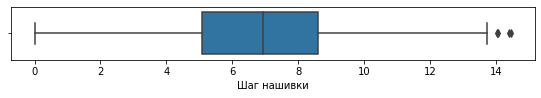

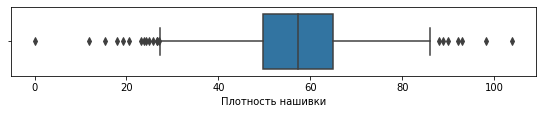

In [23]:
def boxplotdraw(df, variables, n_rows, n_cols):
 for i, var_name in enumerate(variables):
  fig=plt.figure(figsize=(30, 5))
  ax=fig.add_subplot(n_rows,n_cols,i+1)
  sns.boxplot(data=df, x=var_name)
  fig.tight_layout()
  plt.show()

boxplotdraw(df, df.columns, 4, 4)

Выделяются аномальные значения у всех параметров. Являются они выбросами или нет можно проверить так: проведем оценку попадания в интервал до q_3 + з*irq (где q_3 - верхняя квартиль, irq - интерквартильный размах). Всё, что больше q_3 + 3*irq и меньше q_1 - 3*irq, будем удалять.

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


In [25]:
display(df['Угол нашивки, град'].unique())

array([ 0., 90.])

In [26]:
df.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

In [27]:
#Проверяю вручную. Выбираю менее строгий множитель в 1.7 (в сумме будет 3 сигмы, см. https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097)
q1 = df['Плотность нашивки'].quantile(0.25)
q3 = df['Плотность нашивки'].quantile(0.75)
iqr = q3 - q1
anomaly_left  = q1 - 1.7*iqr
anomaly_right = q3 + 1.7*iqr
display(anomaly_left)
display(anomaly_right)

24.05143889508187

90.69273441076113

In [28]:
#Проверяю вручную один столбец
too_low = df.loc[df.loc[:, 'Плотность нашивки'] <= anomaly_left]
too_high = df.loc[df.loc[:, 'Плотность нашивки'] >= anomaly_right]
too_sootn = too_high.merge(too_low,  how = 'outer')
#too_temp.set_index('key', inplace=True)
drop_list_sootn_low = list(too_low.index)
drop_list_sootn_high = list(too_high.index)
display('выбросов слева:', len(drop_list_sootn_low))
display('выбросов справа:',len(drop_list_sootn_high))
display('итого:',len(too_sootn))

'выбросов слева:'

8

'выбросов справа:'

4

'итого:'

12

In [29]:
#Для каждого параметра просматриваю "аномальные" строки
anomalies_drop_set = set()
for column in df:
 d = df.loc[:, [column]]
 q1 = np.quantile(df[column], 0.25)
 q3 = np.quantile(df[column], 0.75)
 iqr = q3 - q1
 lower = q1 - 1.7 * iqr
 upper = q3 + 1.7 * iqr
 d['iqr'] = (df[column] <= lower) | (df[column] >= upper)
 anomalies = d.loc[d.loc[:, 'iqr'] == True]
 total_anomalies = anomalies['iqr'].count()
 anomalies_drop_set = anomalies_drop_set | {x for x in anomalies.index.tolist()}
 print(anomalies)
 print('TOTAL:', total_anomalies)

Empty DataFrame
Columns: [Соотношение матрица-наполнитель, iqr]
Index: []
TOTAL: 0
     Плотность, кг/м3   iqr
100       2207.773481  True
264       2192.297637  True
626       2192.738783  True
873       1740.657496  True
918       1731.764635  True
TOTAL: 5
     модуль упругости, ГПа   iqr
592            1911.536477  True
770            1815.865170  True
TOTAL: 2
     Количество отвердителя, м.%   iqr
257                    17.740275  True
412                   198.953207  True
TOTAL: 2
     Содержание эпоксидных групп,%_2   iqr
2                          33.000000  True
298                        14.254985  True
TOTAL: 2
     Температура вспышки, С_2   iqr
0                  100.000000  True
378                160.255843  True
791                413.273418  True
TOTAL: 3
Empty DataFrame
Columns: [Поверхностная плотность, г/м2, iqr]
Index: []
TOTAL: 0
      Модуль упругости при растяжении, ГПа   iqr
375                              82.682051  True
636                              64.

In [30]:
anomalies_drop_set

{0,
 2,
 19,
 41,
 74,
 100,
 117,
 140,
 185,
 193,
 211,
 233,
 257,
 262,
 264,
 279,
 298,
 348,
 375,
 378,
 412,
 438,
 461,
 464,
 471,
 503,
 592,
 626,
 636,
 770,
 791,
 873,
 918,
 1000}

In [31]:
len(anomalies_drop_set)

34

In [32]:
drop_list = list(anomalies_drop_set)

In [33]:
drop_list

[0,
 257,
 770,
 2,
 193,
 262,
 264,
 74,
 140,
 461,
 592,
 464,
 211,
 19,
 918,
 791,
 471,
 279,
 412,
 348,
 503,
 100,
 1000,
 873,
 298,
 41,
 233,
 626,
 117,
 438,
 375,
 185,
 378,
 636]

In [34]:
df_clean = df.drop(drop_list, axis =0)
print(df_clean.shape)
display(df_clean.tail())

(989, 13)


,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
1018,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669,90.0,9.076380,47.019770
1019,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099,90.0,10.565614,53.750790
1020,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764,90.0,4.161154,67.629684
1021,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,2071.715856,197.126067,90.0,6.313201,58.261074
1022,3.808020,1890.413468,417.316232,129.183416,27.474763,300.952708,758.747882,74.309704,2856.328932,194.754342,90.0,6.078902,77.434468


Убрали из рассмотрения 34 записи. Проверим распределение переменных после удаления выбросов:

In [35]:
df_clean.isna().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

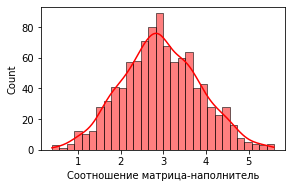

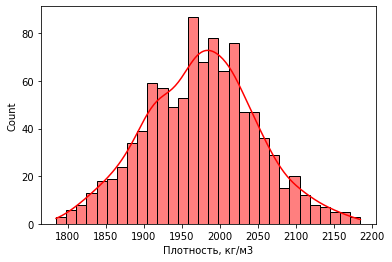

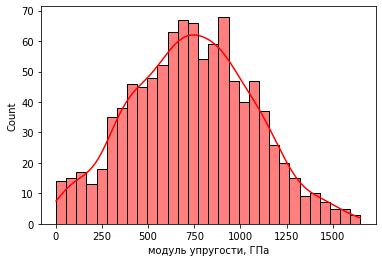

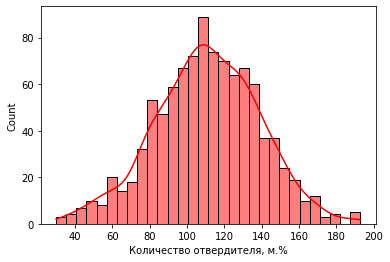

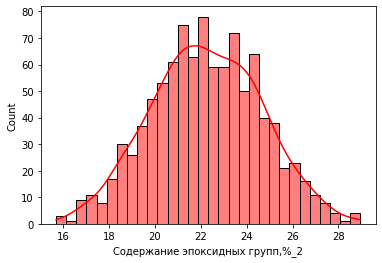

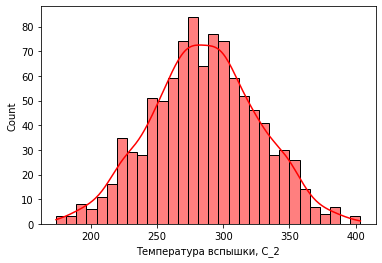

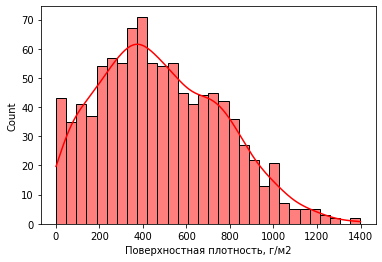

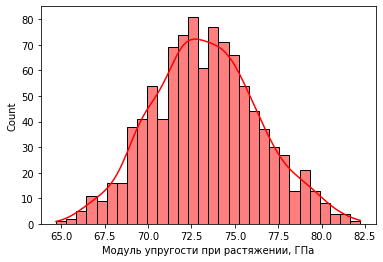

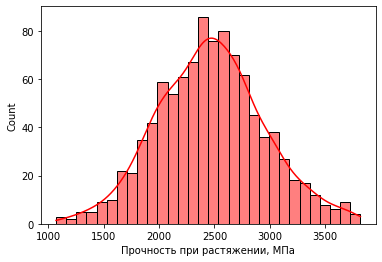

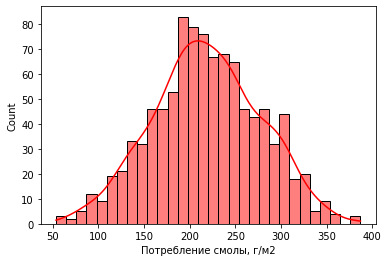

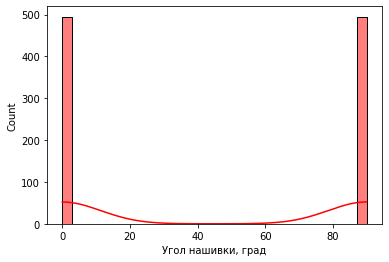

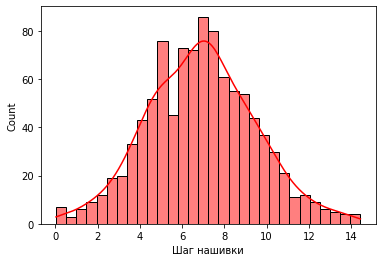

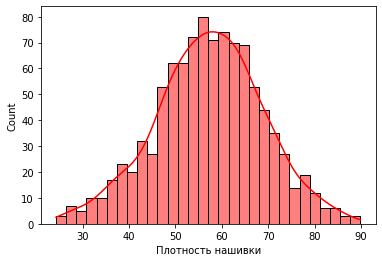

In [36]:
histodraw(df_clean, df_clean.columns, 4, 4)

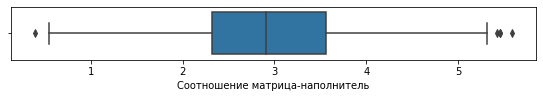

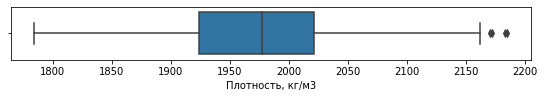

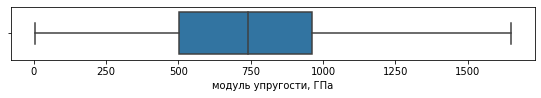

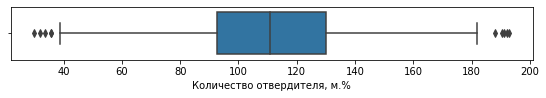

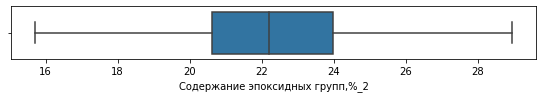

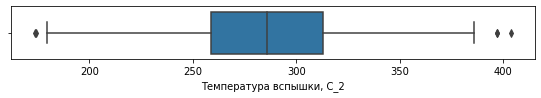

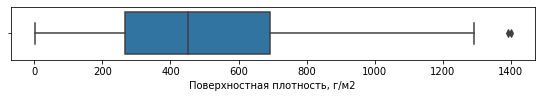

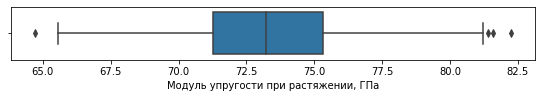

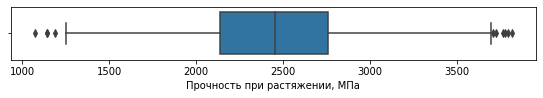

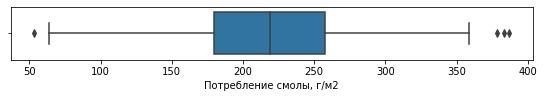

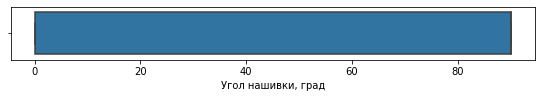

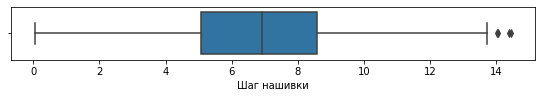

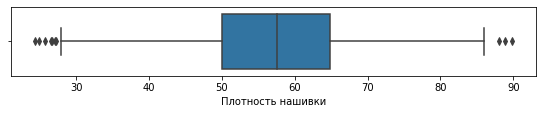

In [37]:
boxplotdraw(df_clean, df_clean.columns, 4, 4)

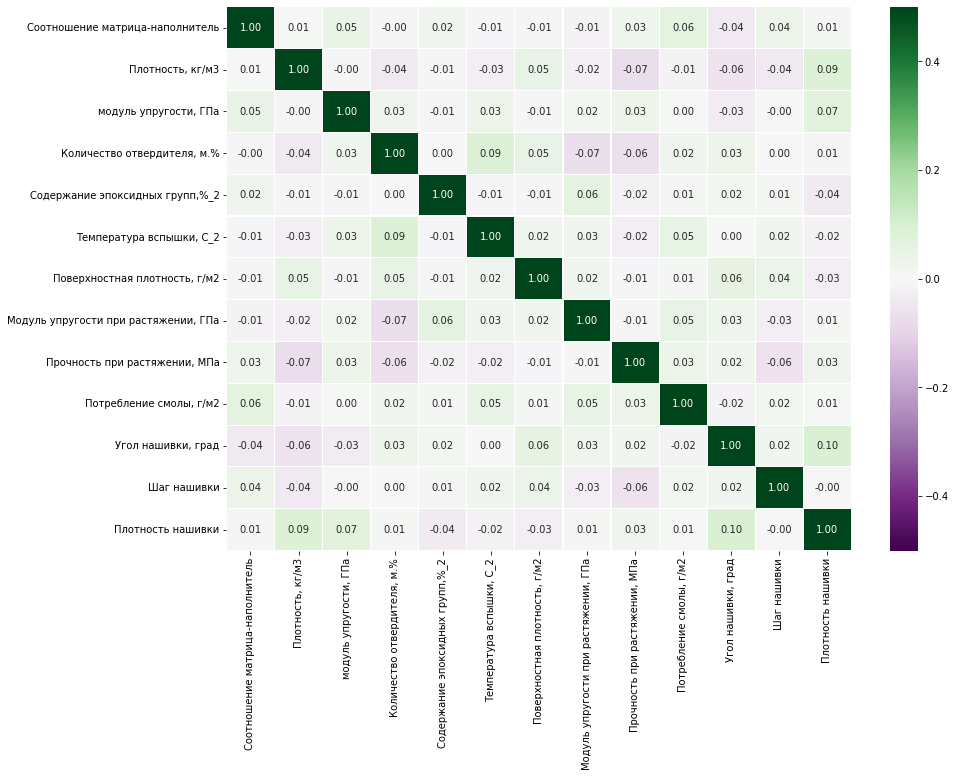

In [38]:
#Визуализация данных с помощью корреляционной матрицы после удаления выбросов
cor_map = df_clean.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cor_map, vmin=-0.5, vmax=0.5, annot=True, 
fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()

Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата. Мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату.Две переменных коллинеарны, когда они находятся между собой в линейной зависимости, если коэффициент корреляции более 0,7. Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из факторов.

Среди наших паременных нет мультиколлинеарных.

In [39]:
df_clean.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

С чем из признаков у целевого признака 'Модуль упругости при растяжении, ГПа' наблюдается наиболее сильная связь?

In [40]:
df_clean.corr()['Модуль упругости при растяжении, ГПа'].sort_values()

Количество отвердителя, м.%            -0.066881
Шаг нашивки                            -0.026982
Плотность, кг/м3                       -0.021587
Соотношение матрица-наполнитель        -0.013930
Прочность при растяжении, МПа          -0.005766
Плотность нашивки                       0.009584
модуль упругости, ГПа                   0.016671
Поверхностная плотность, г/м2           0.022048
Температура вспышки, С_2                0.025408
Угол нашивки, град                      0.027677
Потребление смолы, г/м2                 0.050783
Содержание эпоксидных групп,%_2         0.063805
Модуль упругости при растяжении, ГПа    1.000000
Name: Модуль упругости при растяжении, ГПа, dtype: float64

Параметры "Количество отвердителя", "Потребление смолы" и "Содержание эпоксидных групп" сильнее всего,судя по значению коэффициента корреляции, влияют на модуль упругости конечных материалов 

С чем из признаков у целевого признака 'Прочность при растяжении, МПа ' наблюдается наиболее сильная связь?

In [41]:
df_clean.corr()['Прочность при растяжении, МПа'].sort_values()

Плотность, кг/м3                       -0.073319
Количество отвердителя, м.%            -0.064397
Шаг нашивки                            -0.060914
Температура вспышки, С_2               -0.024998
Содержание эпоксидных групп,%_2        -0.019001
Поверхностная плотность, г/м2          -0.008338
Модуль упругости при растяжении, ГПа   -0.005766
Угол нашивки, град                      0.021994
Плотность нашивки                       0.026710
Соотношение матрица-наполнитель         0.030279
Потребление смолы, г/м2                 0.033061
модуль упругости, ГПа                   0.033648
Прочность при растяжении, МПа           1.000000
Name: Прочность при растяжении, МПа, dtype: float64

Параметры "Количество отвердителя" и "Шаг нашивки" сильнее всего,судя по значению коэффициента корреляции, влияют на прочность при растяжении

# 3. Подготовка данных к моделированию

## 3.1 Train / test 

In [42]:
len(df_clean)

989

In [43]:
#Функция для создания обучающих и валидационных выборок 75:25 для упругости
def split (datafr):
    features = pd.DataFrame(datafr.drop(['Прочность при растяжении, МПа','Модуль упругости при растяжении, ГПа'], axis = 1))
    target = pd.DataFrame(datafr['Модуль упругости при растяжении, ГПа'])
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state = 12345)
    return features_train, features_valid, target_train, target_valid

In [44]:
features_train_upr, features_valid_upr, target_train_upr, target_valid_upr = split(df_clean)

In [45]:
print(features_train_upr.shape)
print(target_train_upr.shape)
print(features_valid_upr.shape)
print(target_valid_upr.shape)

(741, 11)
(741, 1)
(248, 11)
(248, 1)


In [46]:
target_train_upr.sample()

,"Модуль упругости при растяжении, ГПа"
884,76.850058


In [47]:
#Функция для создания обучающих и валидационных выборок 75:25 для прочности
def split_proch (datafr):
    features = pd.DataFrame(datafr.drop(['Прочность при растяжении, МПа','Модуль упругости при растяжении, ГПа'], axis = 1))
    target = pd.DataFrame(datafr['Прочность при растяжении, МПа'])
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state = 12345)
    return features_train, features_valid, target_train, target_valid

In [48]:
features_train_proch, features_valid_proch, target_train_proch, target_valid_proch = split_proch(df_clean)

In [49]:
print(features_train_proch.shape)
print(target_train_proch.shape)
print(features_valid_proch.shape)
print(target_valid_proch.shape)

(741, 11)
(741, 1)
(248, 11)
(248, 1)


In [50]:
target_train_proch.sample()

,"Прочность при растяжении, МПа"
602,2474.731951


In [51]:
features_train_proch.isna().sum()

Соотношение матрица-наполнитель    0
Плотность, кг/м3                   0
модуль упругости, ГПа              0
Количество отвердителя, м.%        0
Содержание эпоксидных групп,%_2    0
Температура вспышки, С_2           0
Поверхностная плотность, г/м2      0
Потребление смолы, г/м2            0
Угол нашивки, град                 0
Шаг нашивки                        0
Плотность нашивки                  0
dtype: int64

## 3.2 Scaling

Посмотрим на масштаб признаков и при необходимости приведем всё  одному масштабу и закодируем переменные.

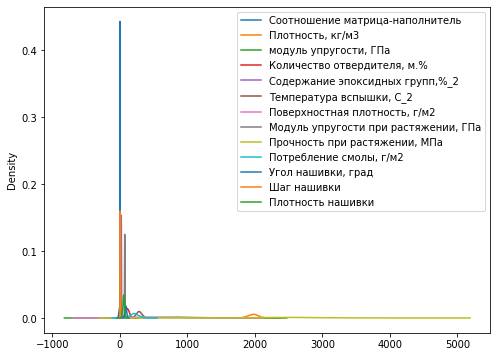

In [59]:
#оценка плотности ядра
fig, ax = plt.subplots(figsize=(8, 6))
df_clean.plot(kind='kde', ax=ax)

In [54]:
#Функция для масштабирования признаков
def scale (features_train, features_valid):
    scaler = MinMaxScaler()
    scaler.fit(features_train) 
    features_train_scaled = scaler.transform(features_train)
    features_train_scaled = pd.DataFrame(features_train_scaled, index = features_train.index, columns = features_train.columns)
    features_valid_scaled = scaler.transform(features_valid)
    features_valid_scaled = pd.DataFrame(features_valid_scaled, index = features_valid.index, columns = features_valid.columns)
    pd.options.mode.chained_assignment = None
    return features_train_scaled, features_valid_scaled

In [55]:
#Приводим к одному масштабу признаки для целевой переменной УПРУГОСТЬ
features_train_UPR_scaled, features_valid_UPR_scaled = scale(features_train_upr, features_valid_upr)

In [56]:
#Приводим к одному масштабу признаки для целевой переменной ПРОЧНОСТЬ
features_train_PRCH_scaled, features_valid_PRCH_scaled = scale(features_train_proch, features_valid_proch)

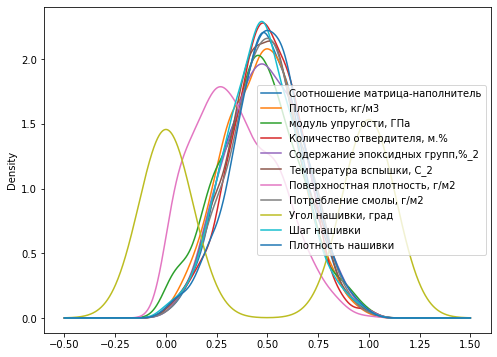

In [58]:
#оценка плотности ядра - обучающие признаки упругсть
fig, ax = plt.subplots(figsize=(8, 6))
features_train_UPR_scaled.plot(kind='kde', ax=ax)

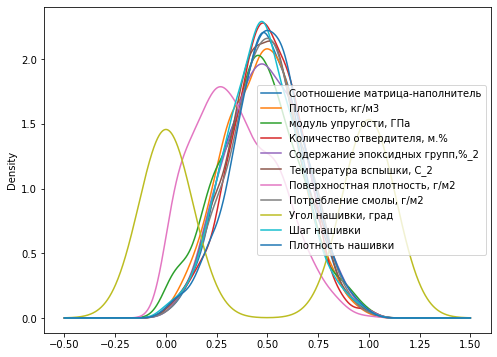

In [60]:
#оценка плотности ядра - обучающие признаки прочность
fig, ax = plt.subplots(figsize=(8, 6))
features_train_PRCH_scaled.plot(kind='kde', ax=ax)

In [65]:
# print(features_train_PRCH_scaled.shape) # Проверяем размер
# print(features_valid_PRCH_scaled.shape)

# print(features_train_PRCH_scaled.head()) #Проверяем соответствие индексов
# print(target_train_proch.head())

# print(features_valid_PRCH_scaled.head()) #Проверяем соответствие индексов
# print(target_valid_proch.head())

In [66]:
# print(features_train_UPR_scaled.shape) # Проверяем размер
# print(features_valid_UPR_scaled.shape)

# print(features_train_UPR_scaled.head()) #Проверяем соответствие индексов
# print(target_train_upr.head())

# print(features_valid_UPR_scaled.head()) #Проверяем соответствие индексов
# print(target_valid_upr.head())

#4. Создание и запуск моделей

Обучим и сравним 4 регресcионные модели:  
1) CatBoost  
2) Многослойный перцептрон  
3) Random Forest Regressor  
4) LinearRegression

Метрика оценки качества моделей - Средняя абсолютная ошибка (MAE).
В MAE ошибка рассчитывается как среднее абсолютных разностей между целевыми значениями и прогнозами. Куски кода,которые долго выполняются, закомментированны.

## 4.1 Константная модель

4.1.1 Для упругости

In [68]:
target_UPR_mean = target_train_upr['Модуль упругости при растяжении, ГПа'].mean()
predicted_const_UPR = pd.Series(target_UPR_mean, index = target_train_upr.index)
predicted_const_df_UPR = pd.DataFrame(predicted_const_UPR)

In [70]:
mae_UPR = mean_absolute_error(target_train_upr, predicted_const_UPR)
print("MAE константной модели для модуля упругости:", mae_UPR)

MAE константной модели для модуля упругости: 2.491977735108044


4.1.2 Для прочности

In [72]:
target_PRCH_mean = target_train_proch['Прочность при растяжении, МПа'].mean()
predicted_const_PRCH = pd.Series(target_PRCH_mean, index = target_train_proch.index)
predicted_const_df_PRCH = pd.DataFrame(predicted_const_PRCH)

In [73]:
mae_PRCH = mean_absolute_error(target_train_proch, predicted_const_df_PRCH)
print("MAE константной модели для прочности:", mae_PRCH)

MAE константной модели для прочности: 383.15462560146733


## Линейная регрессия

In [75]:
#Функция для создания и обучения модели Линейной Регрессии
def model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    mae_LR = mean_absolute_error(target_valid, prediction)
    return prediction, mae_LR

In [76]:
prediction_UPR, score_UPR = model(features_train_UPR_scaled, target_train_upr, features_valid_UPR_scaled, target_valid_upr)

In [77]:
print("Linear Regression упругость")
print("MAE =", score_UPR)

Linear Regression упругость
MAE = 2.404018518015952


In [ ]:
#Смотрим,у каких параметров получилисьбОльшие кофиициенты,и,следовательно, они внесли больший вклад в модель
model = LinearRegression()
model.fit(features_train_UPR_scaled, target_train_upr)

importance = model.coef_[0]
#importance is a list so you can plot it. 
feat_importances = pd.Series(importance, index = features_train_UPR_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance Упругость')

In [81]:
prediction_PRCH, score_PRCH = model(features_train_PRCH_scaled, target_train_proch, features_valid_PRCH_scaled, target_valid_proch)

In [82]:
print("Linear Regression прочность")
print("MAE =", score_PRCH)

Linear Regression прочность
MAE = 366.7622099861159


In [ ]:
#Смотрим,у каких параметров получилисьбОльшие кофиициенты,и,следовательно, они внесли больший вклад в модель
model = LinearRegression()
model.fit(features_train_PRCH_scaled, target_train_proch)

importance = model.coef_[0]
#importance is a list so you can plot it. 
feat_importances = pd.Series(importance, index = features_train_PRCH_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance Прочность')

Результат лишь слегка лучше константной модели

## Random Forest

In [83]:
RF_parameters = {'n_estimators': range (10, 51, 10),
               'max_depth': range (1,13, 2),
               'min_samples_leaf': range (1,8),
               'min_samples_split': range (2,10,2) }

In [84]:
model = RandomForestRegressor()

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)},
             scoring='neg_mean_absolute_error')

In [ ]:
# grid = GridSearchCV(model, RF_parameters , scoring = 'neg_mean_absolute_error')
# grid.fit(features_train_UPR_scaled, target_train_upr)
# print(grid.best_params_)

In [86]:
model = RandomForestRegressor(n_estimators = 30, max_depth = 1, min_samples_leaf = 6, min_samples_split = 2, random_state=12345)
model.fit(features_train_UPR_scaled, target_train_upr)

RandomForestRegressor(max_depth=1, min_samples_leaf=6, n_estimators=30,
                      random_state=12345)

In [87]:
predictions = model.predict(features_valid_UPR_scaled)
mae_RF = mean_absolute_error(target_valid_upr, predictions)

In [88]:
print("RF Regression упругость")
print(" ")
#print("MAE при кросс-валидации:", result.round(3) )
print("MAE =:", mae_RF)
print(" ")

RF Regression упругость
 
MAE =: 2.3935439804888015
 


In [ ]:
# grid = GridSearchCV(model, RF_parameters , scoring = 'neg_mean_absolute_error')
# grid.fit(features_train_PRCH_scaled, target_train_proch)
# print(grid.best_params_)

In [92]:
model = RandomForestRegressor(n_estimators = 30, max_depth = 1, min_samples_leaf = 6, min_samples_split = 2, random_state=12345)
model.fit(features_train_PRCH_scaled, target_train_proch)

RandomForestRegressor(max_depth=1, min_samples_leaf=6, n_estimators=30,
                      random_state=12345)

In [93]:
predictions = model.predict(features_valid_PRCH_scaled)
mae_RF = mean_absolute_error(target_valid_proch, predictions)

In [94]:
print("RF Regression прочность")
print(" ")
#print("MAE при кросс-валидации:", result.round(3) )
print("MAE =:", mae_RF)
print(" ")

RF Regression упругость
 
MAE =: 367.5447726299916
 


## CatBoost

Подберем параметры перебором и применим в модели

In [95]:
parameters = {'depth': [6, 10, 15, 20],
              'iterations'    : [30, 100, 150]}

In [117]:
# model = CatBoostRegressor()
# grid = RandomizedSearchCV(model, parameters, scoring = 'neg_mean_absolute_error')
# grid.fit(features_train_PRCH_scaled, target_train_proch)

In [98]:
print(grid.best_params_)
print(grid.best_score_)

{'iterations': 150, 'depth': 15}
-387.71298337965845


In [100]:
model = CatBoostRegressor(learning_rate=0.1,
                          depth = 15,
                          iterations = 150, 
                          random_state=42, 
                          verbose=False) 
model.fit(features_train_PRCH_scaled, target_train_proch)
pred = model.predict(features_valid_PRCH_scaled)
mae_CB = mean_absolute_error(target_valid_proch, pred)

In [101]:
print("Regression CatBoost упругость")
print(" ")
#print("RMSE при кросс-валидации:", final_score.round(3) )
print("MAE =", mae_CB )

Regression CatBoost упругость
 
MAE = 372.52887008885926


In [102]:
model = CatBoostRegressor(learning_rate=0.1,
                          depth = 15,
                          iterations = 150, 
                          random_state=42, 
                          verbose=False) 
model.fit(features_train_UPR_scaled, target_train_upr)
pred = model.predict(features_valid_UPR_scaled)
mae_CB = mean_absolute_error(target_valid_upr, pred)

In [103]:
print("Regression CatBoost прочность")
print(" ")
#print("RMSE при кросс-валидации:", final_score.round(3) )
print("MAE =", mae_CB )

Regression CatBoost прочность
 
MAE = 2.338747332641737


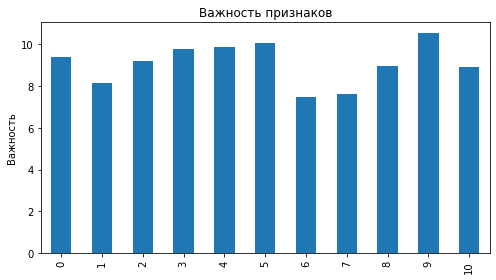

In [121]:
CB_imp = pd.Series(model.feature_importances_)

fig, ax = plt.subplots(figsize=(7,4))
CB_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [122]:
features_train_PRCH_scaled.columns

Index(['Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

## Нейронные сети - многослойный перцептрон

In [113]:
mlpr_model_params = ({
 'hidden_layer_sizes' : [(100, 100, 50, 25, 12), (144, 144, 72, 36,
12, 1), (12, 12, 12, 12, 12),
 (144, 144, 144, 72, 72, 36, 36), ()],
 'activation' : ['identity', 'logistic', 'tanh', 'relu'],
 'solver' : ['sgd', 'adam'],
 'max_iter' : [100],
 'learning_rate' : ['constant', 'adaptive', 'invscaling']
})


In [115]:
mlpr_model = MLPRegressor(random_state=14)

In [119]:
# GSCV_mlpr_model_PRCH = GridSearchCV(mlpr_model, mlpr_model_params, n_jobs=-1, cv=10)
# GSCV_mlpr_model_PRCH.fit(features_train_PRCH_scaled, target_train_proch)

GridSearchCV(cv=10, estimator=MLPRegressor(random_state=14), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100, 100, 50, 25, 12),
                                                (144, 144, 72, 36, 12, 1),
                                                (12, 12, 12, 12, 12),
                                                (144, 144, 144, 72, 72, 36, 36),
                                                ()],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'max_iter': [100], 'solver': ['sgd', 'adam']})

In [120]:
# GSCV_mlpr_model_PRCH.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (12, 12, 12, 12, 12),
 'learning_rate': 'constant',
 'max_iter': 100,
 'solver': 'sgd'}

In [123]:
mlpr_model_PRCH = GSCV_mlpr_model_PRCH.best_estimator_

In [124]:
regr_MLPR = mlpr_model_PRCH.fit(features_train_PRCH_scaled, target_train_proch)
pred_MLPR = regr_MLPR.predict(features_valid_PRCH_scaled)
mae_MLPR = mean_absolute_error(target_valid_proch, pred_MLPR)

In [125]:
print("Regression MLPRegressor прочность")
print(" ")
#print("RMSE при кросс-валидации:", final_score.round(3) )
print("MAE =", mae_MLPR )

Regression MLPRegressor прочность
 
MAE = 368.4737117432839


In [132]:
GSCV_mlpr_model_UPR = GridSearchCV(mlpr_model, mlpr_model_params, n_jobs=-1, cv=10)
GSCV_mlpr_model_UPR.fit(features_train_UPR_scaled, target_train_upr)

GridSearchCV(cv=10, estimator=MLPRegressor(random_state=14), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100, 100, 50, 25, 12),
                                                (144, 144, 72, 36, 12, 1),
                                                (12, 12, 12, 12, 12),
                                                (144, 144, 144, 72, 72, 36, 36),
                                                ()],
                         'learning_rate': ['constant', 'adaptive',
                                           'invscaling'],
                         'max_iter': [100], 'solver': ['sgd', 'adam']})

In [133]:
GSCV_mlpr_model_UPR.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (144, 144, 144, 72, 72, 36, 36),
 'learning_rate': 'constant',
 'max_iter': 100,
 'solver': 'sgd'}

In [134]:
mlpr_model_UPR = GSCV_mlpr_model_UPR.best_estimator_

In [135]:
regr_MLPR = mlpr_model_UPR.fit(features_train_UPR_scaled, target_train_upr)
pred_MLPR = regr_MLPR.predict(features_valid_UPR_scaled)
mae_MLPR = mean_absolute_error(target_valid_upr, pred_MLPR)

In [136]:
print("Regression MLPRegressor упругость")
print(" ")
print("MAE =", mae_MLPR )

Regression MLPRegressor упругость
 
MAE = 2.3585606445005594


# 5. Выводы

In [126]:
table_UPR = pd.DataFrame({'Модель': ["Константная", "Linear Regression", "RF Regression", "Regression CatBoost", "MLPRegressor"],
                      'MAE':[383.15, 366.76, 367.54, 372.53, 368.47]})

In [131]:
display("Упругость. Минимальные абсолютные ошибки моделей")
display(table_UPR.sort_values(by='MAE'))

'Упругость. Минимальные абсолютные ошибки моделей'

,Модель,MAE
1,Linear Regression,366.76
2,RF Regression,367.54
4,MLPRegressor,368.47
3,Regression CatBoost,372.53
0,Константная,383.15


In [137]:
table_PROCH = pd.DataFrame({'Модель': ["Константная", "Linear Regression", "RF Regression", "Regression CatBoost", "MLPRegressor"],
                      'MAE':[2.49, 2.40, 2.39, 2.34, 2.35]})

In [138]:
display("Прочность. Минимальные абсолютные ошибки моделей")
display(table_PROCH.sort_values(by='MAE'))

'Прочность. Минимальные абсолютные ошибки моделей'

,Модель,MAE
3,Regression CatBoost,2.34
4,MLPRegressor,2.35
2,RF Regression,2.39
1,Linear Regression,2.40
0,Константная,2.49


Выводы: ни одна из переменных линейно не связана с целевой переменной. При этом для предсказания модуля упругости лучшие значения показывает простая модель линейной регрессии (вероятно, из-за большого веса признака "Количество отвердителя"). Для предсказания прочности лучшей моделью поданным эксперимента стала модель CatBoost. Однако имеющихся признаков недостаточно (или имеющиеся данные не подходят по смыслу) для значительно более точной, чем даёт константная модель, предсказаний характеристик композиционного материала.